In [1]:
import sys
sys.path.append("..")

from models.taylorf2 import taylorf2
import jax.numpy as jnp
from jax import grad, config
import jax
import matplotlib.pyplot as plt
import os 
import numpy as np
config.update("jax_enable_x64", True)
import corner

In [2]:
jax.devices()

[gpu(id=0)]

# Instantiate model class

In [3]:
injection = jnp.array([0, 0, 30.0, 0.24, 0.05]) 

# Define prior ranges
priorDict = {}
priorDict[0] = injection[0] + jnp.array([-0.001, 0.001])
priorDict[1] = jnp.array([-jnp.pi, jnp.pi])
priorDict[2] = jnp.array([27.5, 32.5])
priorDict[3] = jnp.array([0.2, 0.249])
priorDict[4] = jnp.array([0.02, 0.07])

# Instantiate model
model = taylorf2(injection, priorDict)

SNR is: 18.549376129849225


# What does the strain look like?

In [ ]:
plt.plot(model.frequency, model.strain(injection, model.frequency).imag, label='Imaginary')
plt.plot(model.frequency, model.strain(injection, model.frequency).real, label='Real')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')
plt.legend()
plt.title('Gravitational wave strain data')

# Run some quick checks on the derivatives

In [ ]:
x = model.injection + np.random.uniform(low=0, high=0.0001, size=5)

print('Make sure autodiff and analytically calculated gradient of strain agree')
print(jax.jacfwd(model.strain)(x,10))
print(model.gradient_strain(x, 10))

# -------------------------------------------------------------------------------

print('Make sure derivative of potentials agree')
print(jax.jacfwd(model.potential_single)(x))
print(model.gradient_potential_single(x))

# -------------------------------------------------------------------------------

print('Make sure Jacobian calculation is stable')
print(jax.jacrev(model.potential_single)(x))
print(jax.jacfwd(model.potential_single)(x))

In [ ]:
# Calculate cross sections of PDF

def getCrossSection(index1, index2, func, injection, lower_bound, upper_bound, index_label, ngrid=200):
    DoF = len(injection)
    x = np.linspace(lower_bound[index1], upper_bound[index1], ngrid)
    y = np.linspace(lower_bound[index2], upper_bound[index2], ngrid)
    X, Y = np.meshgrid(x, y)
    particle_grid = np.zeros((ngrid ** 2, DoF))
    parameter_mesh = np.vstack((np.ndarray.flatten(X), np.ndarray.flatten(Y))).T

    particle_grid[:, index1] = parameter_mesh[:, 0]
    particle_grid[:, index2] = parameter_mesh[:, 1]
    for i in range(DoF): # Fix all other parameters
        if i != index1 and i != index2:
            particle_grid[:, i] = np.ones(ngrid ** 2) * injection[i]

    Z = func(particle_grid).reshape(ngrid,ngrid)

    fig, ax = plt.subplots(figsize = (5, 5))
    cp = ax.contourf(X, Y, Z)
    plt.colorbar(cp)
    ax.set_xlabel(index_label[index1])
    ax.set_ylabel(index_label[index2])
    ax.set_title('Cross section of PDF')
    filename = str(index1) + str(index2) + '.png'
    path = os.path.join('marginals', filename)
    # fig.savefig(path)

posterior = lambda X: np.exp(-1 * model.getMinusLogPosterior_ensemble(X))

neg_potential = lambda X: -1 * model.getMinusLogPosterior_ensemble(X)

for i in range(5):
    for j in range(i+1, 5):
        # print('Getting cross section for %s' % pair)
        getCrossSection(i, j, neg_potential, injection, model.lower_bound, model.upper_bound, model.index_label)

# Try sampling from model with `jaxns`

In [5]:
# from jax.config import config

# config.update("jax_enable_x64", True)

# import pylab as plt
import tensorflow_probability.substrates.jax as tfp
# from jax import random, numpy as jnp
from jax import random
# from jax import vmap

# import jaxns
from jaxns import ExactNestedSampler
from jaxns import Model
from jaxns import PriorModelGen, Prior
from jaxns import TerminationCondition

tfpd = tfp.distributions

In [12]:
def prior_model() -> PriorModelGen:
    x = yield Prior(tfpd.Uniform(low=model.lower_bound, high=model.upper_bound), name='x')
    return x

jaxns_model = Model(prior_model=prior_model, log_likelihood=lambda x: -1 * model.potential_single(x))

exact_ns = ExactNestedSampler(model=jaxns_model, num_live_points=1000, num_parallel_samplers=1, max_samples=1e5)

termination_reason, state = exact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-5))

# termination_reason, state = exact_ns(random.PRNGKey(42), term_cond=TerminationCondition(max_samples=1e5))
# termination_reason, state = exact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))

results = exact_ns.to_results(state, termination_reason)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 792610
# samples: 20000
# slices: 240000.0
# slices / acceptance: 15.0
# likelihood evals / sample: 39.6
# likelihood evals / slice: 3.2
--------
logZ=974.28 +- 0.12
H=inf
ESS=2821
--------
x[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x[0]: 1.5e-05 +- 7e-05 | -7.7e-05 / 1.6e-05 / 0.000108 | -1.1e-05 | -1.1e-05
x[1]: -0.6 +- 3.0 | -3.1 / -2.9 / 3.1 | 3.1 | 3.1
x[2]: 30.08 +- 0.1 | 29.96 / 30.08 / 30.21 | 30.05 | 30.05
x[3]: 0.226 +- 0.013 | 0.207 / 0.226 / 0.244 | 0.234 | 0.234
x[4]: 0.06994 +- 6.1e-05 | 0.06986 / 0.069958 / 0.069993 | 0.07 | 0.07
--------


WARNING[2023-09-18 15:25:15,616]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


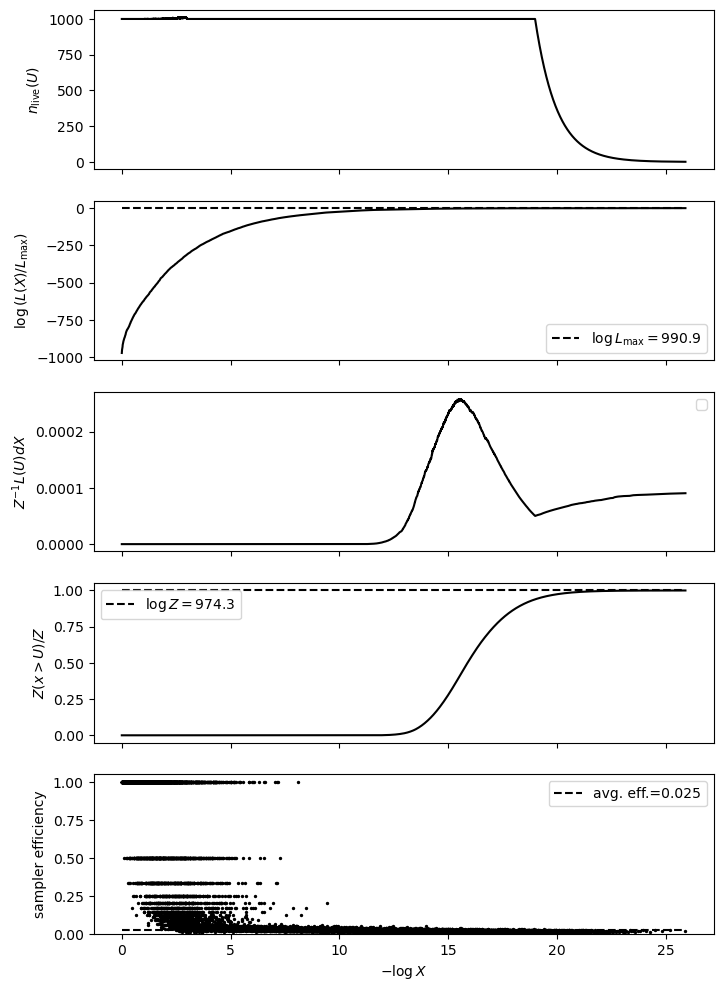

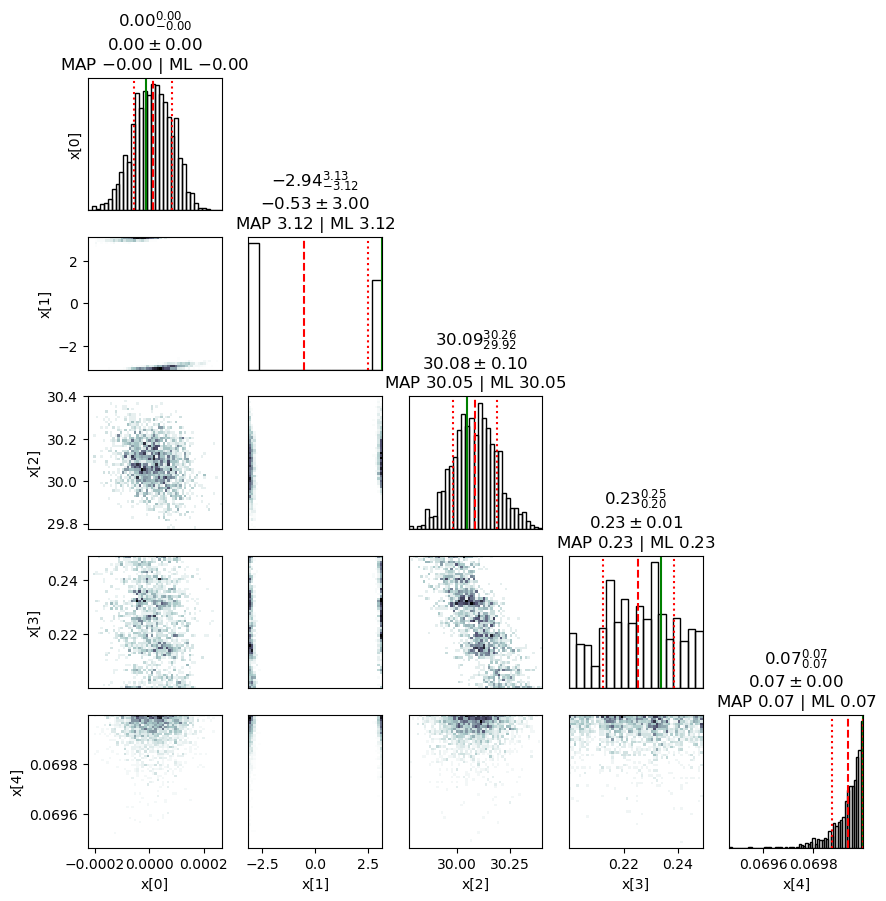

In [13]:
exact_ns.summary(results)
exact_ns.plot_diagnostics(results)
exact_ns.plot_cornerplot(results)

# Try getting it working with `Bilby`